In [111]:
## load the libraries 
%matplotlib inline
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.metrics import *
from keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from keras.preprocessing import image
from keras import datasets

from keras import backend as K
import random
import matplotlib.pyplot as plt
from skimage import exposure
plt.gray()

os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0

<Figure size 432x288 with 0 Axes>

In [112]:
def load_image(path):
    x_size = 64
    y_size = 64
    image_list = np.zeros((len(path), x_size, y_size,1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, grayscale=True, target_size=(x_size, y_size))
        img = image.img_to_array(img).astype('float32')
        img = img / 255.0
        '''
        max_i = img.max()
        min_i = img.min()

        img = (img - min_i) / (max_i - min_i)
        '''
        
        image_list[i] = img#[:,:,1].reshape(64,64,1)#exposure.equalize_adapthist(img[:,:,0])
        
    return image_list

In [113]:
"""
train_img = glob.glob("/home/webvalley/Documents/plaque-image-preprocessing/Data/Patches/Plaque/Aug/cal/*.png")
train_img += glob.glob("/home/webvalley/Documents/plaque-image-preprocessing/Data/Patches/Plaque/Aug/fibrous/*.png")
train_img += random.sample(glob.glob("/home/webvalley/Documents/plaque-image-preprocessing/Data/Patches/NoPlaque/*.png"), 3790)
"""
train_img = glob.glob("train/*.png")

test_img = glob.glob("test/*.png")


random.shuffle(train_img)
random.shuffle(test_img)

x_train = load_image(train_img)
x_test = load_image(test_img) 
img = x_train[0]

In [114]:
for i, img in enumerate(x_train):
    max_i = img.max()
    min_i = img.min()
    if max_i == min_i:
        img = np.zeros((64,64,1))
    else:
        img = (img - min_i) / (max_i - min_i)
        img = exposure.equalize_adapthist(img[:,:,0])
    
    x_train[i] = img.reshape(64,64,1)

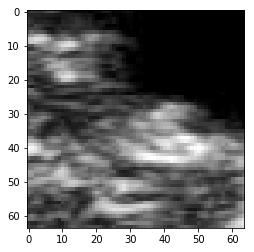

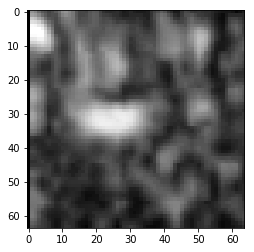

In [101]:
plt.imshow(img.reshape(64,64))
plt.show()

plt.imshow(x_train[0].reshape(64,64))
plt.show()


In [115]:
"""
imgs = glob.glob("/home/webvalley/Documents/plaque-image-preprocessing/AutoEncoder/test/*.png")
print(imgs[len(imgs)-1])


for _ in range(200):
    r = random.randint(0, len(imgs)-1)
    name = imgs[r].split("/")[-1]
    while not "noplaque" in name:
        r = random.randint(0, len(imgs))
        name = imgs[r].split("/")[-1]
    
    print('mv "' + imgs[r] + '" /home/webvalley/Documents/plaque-image-preprocessing/AutoEncoder/train')

    os.system('mv "' + imgs[r] + '" /home/webvalley/Documents/plaque-image-preprocessing/AutoEncoder/train')


for im in glob.glob("/home/webvalley/Documents/plaque-image-preprocessing/Data/Patches/Plaque/Aug/cal/*.png"):
    #print(im)
    os.system(f"cp {im} train")
"""

'\nimgs = glob.glob("/home/webvalley/Documents/plaque-image-preprocessing/AutoEncoder/test/*.png")\nprint(imgs[len(imgs)-1])\n\n\nfor _ in range(200):\n    r = random.randint(0, len(imgs)-1)\n    name = imgs[r].split("/")[-1]\n    while not "noplaque" in name:\n        r = random.randint(0, len(imgs))\n        name = imgs[r].split("/")[-1]\n    \n    print(\'mv "\' + imgs[r] + \'" /home/webvalley/Documents/plaque-image-preprocessing/AutoEncoder/train\')\n\n    os.system(\'mv "\' + imgs[r] + \'" /home/webvalley/Documents/plaque-image-preprocessing/AutoEncoder/train\')\n\n\nfor im in glob.glob("/home/webvalley/Documents/plaque-image-preprocessing/Data/Patches/Plaque/Aug/cal/*.png"):\n    #print(im)\n    os.system(f"cp {im} train")\n'

In [115]:
y_test = []

for img in test_img:
    if "Calcific" in img:
        y_test.append(0)
    elif "Fibrous" in img:
        y_test.append(1)
    elif "noplaque" in img:
        y_test.append(2)

In [117]:
batch_size = 128
epochs = 200
inChannel = 1
x, y = 64, 64
input_img = Input(shape = (x, y, inChannel))
print(input_img.shape)

(?, 64, 64, 1)


In [174]:
img_rows, img_cols, img_chns = x, y, 1
# number of convolutional filters to use
NB_FILTERS = 16
# convolution kernel size
KERNEL_SIZE = (3, 3)


LATENT_DIM = 128
INTERMEDIATE_DIM = 256
NB_EPOCHS = 100

conv_1 = Conv2D(1, kernel_size=(2, 2), padding='same', activation='relu')(input_img)
conv_2 = Conv2D(NB_FILTERS, kernel_size=(2, 2),
                       padding='same', activation='relu',
                       strides=(2, 2))(conv_1)
conv_3 = Conv2D(NB_FILTERS, KERNEL_SIZE,
                       padding='same', activation='relu',
                       strides=(1, 1))(conv_2)
conv_4 = Conv2D(NB_FILTERS, KERNEL_SIZE,
                       padding='same', activation='relu',
                       strides=(1, 1))(conv_3)
flat = Reshape((-1,))(conv_4)

dropout1 = Dropout(rate=0.5)(flat)
hidden = Dense(INTERMEDIATE_DIM, activation='relu')(dropout1)
dropout2 = Dropout(rate=0.5)(hidden)

z = Dense(LATENT_DIM)(dropout2)

decoder_hid = Dense(INTERMEDIATE_DIM, activation='relu')(z)

dropout3 = Dropout(rate=0.5)(decoder_hid)
decoder_upsample = Dense(NB_FILTERS * img_rows//2 * img_rows//2, activation='relu')(dropout3)
dropout4 = Dropout(rate=0.5)(decoder_upsample)

decoder_reshape = Reshape((img_rows//2, img_rows//2, NB_FILTERS))(dropout4)
decoder_deconv_1 = Conv2DTranspose(NB_FILTERS, KERNEL_SIZE,
                                   padding='same',
                                   strides=(1, 1),
                                   activation='relu')(decoder_reshape)
decoder_deconv_2 = Conv2DTranspose(NB_FILTERS, KERNEL_SIZE,
                                   padding='same',
                                   strides=(1, 1),
                                   activation='relu')(decoder_deconv_1)

decoder_deconv_3_upsamp = Conv2DTranspose(NB_FILTERS, kernel_size=(2, 2),
                                          padding='valid',
                                          strides=(2, 2),
                                          activation='relu')(decoder_deconv_2)
decoder_mean_squash = Conv2D(img_chns, kernel_size=(1, 1),
                                    padding='valid',
                                    activation='sigmoid')(decoder_deconv_3_upsamp)


In [173]:
"""FUNZIONANTE
# Encoder
encoded = Conv2D(2,(3,3),
           activation='relu',
           padding='same')(input_img)
encoded = Conv2D(2,(3,3),
           activation='relu',
           padding='same')(encoded)
encoded = MaxPooling2D((2,2))(encoded) 
encoded = Conv2D(4,(3,3),
           activation='relu',
           padding='same')(encoded)
encoded = Conv2D(4,(3,3),
           activation='relu',
           padding='same')(encoded)
encoded = MaxPooling2D((2,2))(encoded) 
encoded = Flatten()(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(4)(encoded)

# Decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(1024, activation='relu')(decoded)
decoded = Reshape((7,7,4))(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(4, (3, 3),
           activation='relu',
           padding='same')(decoded)
decoded = Conv2D(2, (3, 3),
           activation='relu',
           padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded) 
decoded = Conv2D(2, (3, 3),
           activation='relu',
           padding='same')(decoded)
decoded = Conv2D(1, (3, 3),
           padding='same')(decoded)
"""

"FUNZIONANTE\n# Encoder\nencoded = Conv2D(2,(3,3),\n           activation='relu',\n           padding='same')(input_img)\nencoded = Conv2D(2,(3,3),\n           activation='relu',\n           padding='same')(encoded)\nencoded = MaxPooling2D((2,2))(encoded) \nencoded = Conv2D(4,(3,3),\n           activation='relu',\n           padding='same')(encoded)\nencoded = Conv2D(4,(3,3),\n           activation='relu',\n           padding='same')(encoded)\nencoded = MaxPooling2D((2,2))(encoded) \nencoded = Flatten()(encoded)\nencoded = Dense(64, activation='relu')(encoded)\nencoded = Dense(4)(encoded)\n\n# Decoder\ndecoded = Dense(64, activation='relu')(encoded)\ndecoded = Dense(1024, activation='relu')(decoded)\ndecoded = Reshape((7,7,4))(decoded)\ndecoded = UpSampling2D((2, 2))(decoded)\ndecoded = Conv2D(4, (3, 3),\n           activation='relu',\n           padding='same')(decoded)\ndecoded = Conv2D(2, (3, 3),\n           activation='relu',\n           padding='same')(decoded)\ndecoded = UpSampli

In [167]:
"""
# encoding architecture
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
print(encoded.shape)
encoded = MaxPool2D( (2, 2), padding='same')(encoded)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPool2D( (2, 2), padding='same')(encoded)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPool2D((2, 2), padding='same')(encoded)
encoded = Flatten()(encoded)
encoded = Dense(128)(encoded)
encoded = Dense(2)(encoded)
"""

"\n# encoding architecture\nencoded = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)\nprint(encoded.shape)\nencoded = MaxPool2D( (2, 2), padding='same')(encoded)\nencoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)\nencoded = MaxPool2D( (2, 2), padding='same')(encoded)\nencoded = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)\nencoded = MaxPool2D((2, 2), padding='same')(encoded)\nencoded = Flatten()(encoded)\nencoded = Dense(128)(encoded)\nencoded = Dense(2)(encoded)\n"

In [168]:
"""
# decoding architecture
decoded = Dense(256)(encoded)
decoded = Reshape((4, 4, 16))(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(1, (3, 3), padding='same')(decoded)
"""

"\n# decoding architecture\ndecoded = Dense(256)(encoded)\ndecoded = Reshape((4, 4, 16))(decoded)\ndecoded = UpSampling2D((2, 2))(decoded)\ndecoded = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded)\ndecoded = UpSampling2D((2, 2))(decoded)\ndecoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)\ndecoded = UpSampling2D((2, 2))(decoded)\ndecoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)\ndecoded = UpSampling2D((2, 2))(decoded)\ndecoded = Conv2D(1, (3, 3), padding='same')(decoded)\n"

In [169]:
"""
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
"""

'\nsmooth = 1\n\ndef dice_coef(y_true, y_pred):\n    y_true_f = K.flatten(y_true)\n    y_pred_f = K.flatten(y_pred)\n    intersection = K.sum(y_true_f * y_pred_f)\n    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)\n\ndef dice_coef_loss(y_true, y_pred):\n    return 1 - dice_coef(y_true, y_pred)\n'

In [175]:
# compile the model

model = Model(input_img, decoder_mean_squash)
model.compile(optimizer=Adam(lr=0.0001), loss='mse')#dice_coef_loss, metrics=[dice_coef])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 1)         5         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 16)        80        
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
reshape_13 (Reshape)         (None, 16384)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16384)             0         
__________

In [176]:
#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model.fit(x_train, x_train, epochs=100, batch_size=batch_size, validation_data=(x_test, x_test))#, callbacks=[early_stopping])

Train on 6981 samples, validate on 599 samples
Epoch 1/100
6981/6981 [==============================] - 5s 689us/step - loss: 0.0745 - val_loss: 0.1286
Epoch 2/100
6981/6981 [==============================] - 3s 426us/step - loss: 0.0730 - val_loss: 0.1244
Epoch 3/100
6981/6981 [==============================] - 3s 425us/step - loss: 0.0698 - val_loss: 0.1100
Epoch 4/100
6981/6981 [==============================] - 3s 427us/step - loss: 0.0525 - val_loss: 0.0544
Epoch 5/100
6981/6981 [==============================] - 3s 428us/step - loss: 0.0463 - val_loss: 0.0467
Epoch 6/100
6981/6981 [==============================] - 3s 429us/step - loss: 0.0420 - val_loss: 0.0365
Epoch 7/100
6981/6981 [==============================] - 3s 426us/step - loss: 0.0389 - val_loss: 0.0290
Epoch 8/100
6981/6981 [==============================] - 3s 427us/step - loss: 0.0370 - val_loss: 0.0246
Epoch 9/100
6981/6981 [==============================] - 3s 427us/step - loss: 0.0361 - val_loss: 0.0253
Epoch 10

Epoch 78/100
6981/6981 [==============================] - 3s 434us/step - loss: 0.0231 - val_loss: 0.0049
Epoch 79/100
6981/6981 [==============================] - 3s 432us/step - loss: 0.0231 - val_loss: 0.0050
Epoch 80/100
6981/6981 [==============================] - 3s 435us/step - loss: 0.0231 - val_loss: 0.0047
Epoch 81/100
6981/6981 [==============================] - 3s 430us/step - loss: 0.0230 - val_loss: 0.0050
Epoch 82/100
6981/6981 [==============================] - 3s 435us/step - loss: 0.0230 - val_loss: 0.0048
Epoch 83/100
6981/6981 [==============================] - 3s 432us/step - loss: 0.0229 - val_loss: 0.0047
Epoch 84/100
6981/6981 [==============================] - 3s 430us/step - loss: 0.0229 - val_loss: 0.0050
Epoch 85/100
6981/6981 [==============================] - 3s 430us/step - loss: 0.0229 - val_loss: 0.0050
Epoch 86/100
6981/6981 [==============================] - 3s 433us/step - loss: 0.0229 - val_loss: 0.0047
Epoch 87/100
6981/6981 [======================

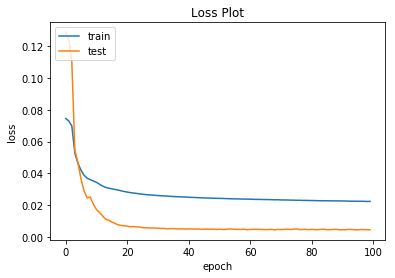

In [177]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [178]:
from keras.models import load_model

model.save('autoencoder_model_3.h5') 

In [179]:
# compile the model

# adam = optimizers.Adam(lr=0.01)

encoder = Model(input_img, z)
encoder.compile(optimizer=Adam(lr=0.0001), loss='mse')#dice_coef, metrics=[dice_coef_loss])

In [180]:
img = x_train[0]

In [181]:
img.shape

(64, 64, 1)

In [182]:

encoded_imgs = encoder.predict(x_test)
decoded_imgs = model.predict(x_test)

In [183]:
encoded_imgs.shape
#print(encoded_imgs[0].shape)

(599, 128)

In [184]:
encoded_imgs[0].shape

(128,)

In [185]:
encoded_imgs[0]

array([-0.21862999,  0.19624242,  0.10806061, -0.03839843,  0.53825927,
        0.9235231 , -0.3624959 ,  1.4059242 , -0.24256141, -0.0683598 ,
        0.54977095,  1.11322   , -0.20300214, -1.0008483 ,  0.14147691,
       -0.04658435,  0.11530825, -0.92339003,  0.40071017,  0.7340709 ,
        0.0344912 ,  0.7623181 , -0.47550887,  0.65381515, -0.2683216 ,
        0.24749513, -0.87334675,  0.24017859,  0.10760204, -0.6521065 ,
       -0.34994867,  0.5051348 ,  1.0765097 ,  0.03863914, -0.5680535 ,
        0.1756065 ,  0.38832843, -0.5617976 , -0.7573116 ,  0.13707012,
       -0.69657505, -0.1032415 , -0.8805069 , -1.0229065 ,  0.35060924,
        0.39200467, -0.33339235,  0.03930147, -0.04532144,  1.1031765 ,
        0.79905796, -0.0961996 , -0.6925672 , -0.22076033, -0.65417796,
        0.75251347,  0.08442548,  0.7246927 , -0.39749828,  0.30128843,
        0.14337075,  0.15438798,  1.2433766 , -0.5219344 , -0.9180628 ,
       -0.25992572, -0.01225119, -0.38736358, -0.20148236, -0.39

In [186]:
label_conv = {
    0: 'Calcific',
    1: 'Fibrous',
    2: 'NoPlaque'
}

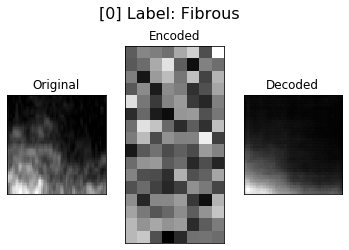

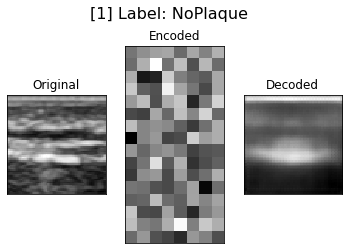

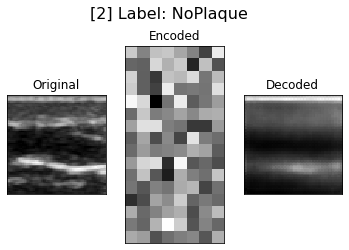

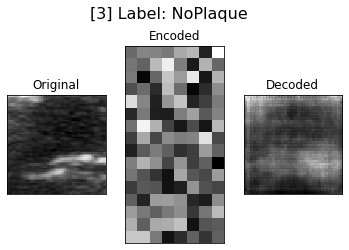

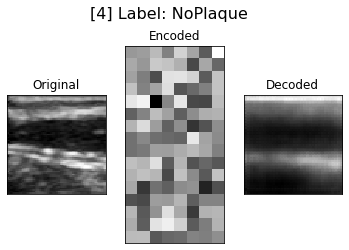

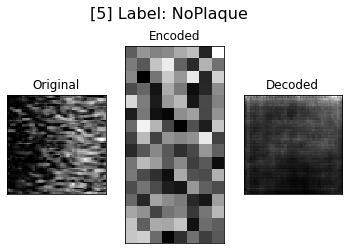

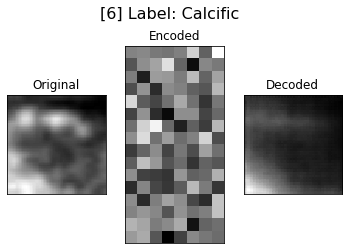

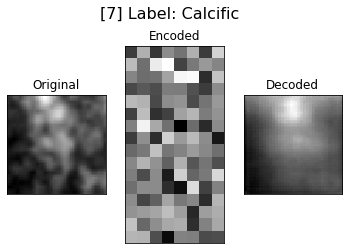

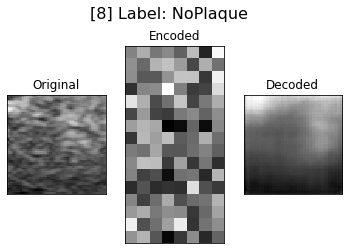

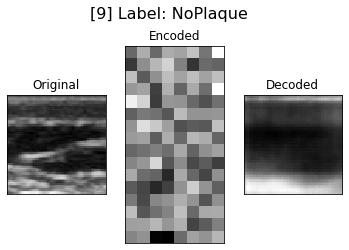

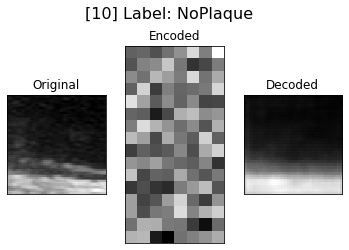

In [187]:

for i in range(11):
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
    
    fig.suptitle(f"[{i}] Label: " + label_conv[y_test[i]], fontsize=16)
    
    ax1.imshow(x_test[i].reshape((64, 64)))
    ax1.set_title("Original")
    
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    ax2.imshow(encoded_imgs[i].reshape((16, 8)))
    ax2.set_title("Encoded")
    
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    ax3.imshow(decoded_imgs[i].reshape((64, 64)))
    ax3.set_title("Decoded")
    
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    plt.show()

In [188]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(encoded_imgs[2].reshape(1,-1), encoded_imgs[1].reshape(1,-1))

In [189]:
cos_sim

array([[0.54883707]], dtype=float32)

In [190]:
np.sum(np.subtract(encoded_imgs[0], encoded_imgs[5]))

0.10828996

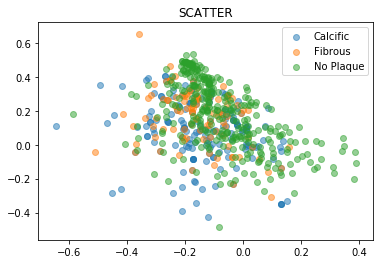

In [191]:
#encoded_imgs[np.array(y_test) == 1]
plt.title("SCATTER")
plt.scatter(encoded_imgs[np.array(y_test) == 0][:, 0], encoded_imgs[np.array(y_test) == 0][:, 1], label='Calcific', alpha=0.5)
plt.scatter(encoded_imgs[np.array(y_test) == 1][:, 0], encoded_imgs[np.array(y_test) == 1][:, 1], label='Fibrous', alpha=0.5)
plt.scatter(encoded_imgs[np.array(y_test) == 2][:, 0], encoded_imgs[np.array(y_test) == 2][:, 1], label='No Plaque', alpha=0.5)
plt.legend();

In [192]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
proj = pca.fit_transform(encoded_imgs)

In [193]:
len(proj)

599

In [194]:
len(pca.components_)

3

In [195]:
pca.explained_variance_

array([6.0914803 , 0.69661844, 0.5405742 ], dtype=float32)

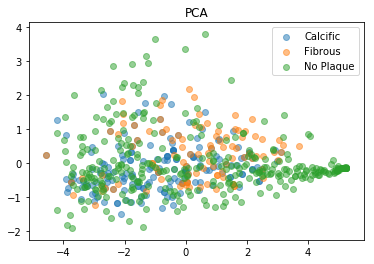

In [196]:
plt.title("PCA")
plt.scatter(proj[np.array(y_test) == 0][:, 0], proj[np.array(y_test) == 0][:, 1], label='Calcific', alpha=0.5)
plt.scatter(proj[np.array(y_test) == 1][:, 0], proj[np.array(y_test) == 1][:, 1], label='Fibrous', alpha=0.5)
plt.scatter(proj[np.array(y_test) == 2][:, 0], proj[np.array(y_test) == 2][:, 1], label='No Plaque', alpha=0.5)
plt.legend();

In [197]:
import umap


standard_embedding = umap.UMAP(random_state=42).fit_transform(encoded_imgs)
"""
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y_test, cmap='Spectral', alpha=0.5)
plt.colorbar();
"""

"\nplt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y_test, cmap='Spectral', alpha=0.5)\nplt.colorbar();\n"

In [198]:
standard_embedding

array([[ 2.0627477, -2.726496 ],
       [ 4.8073034,  4.3118825],
       [ 3.6639705,  3.9632597],
       ...,
       [ 3.2636876,  0.7513871],
       [ 1.6360357, -5.095142 ],
       [ 3.5274892, -2.8484237]], dtype=float32)

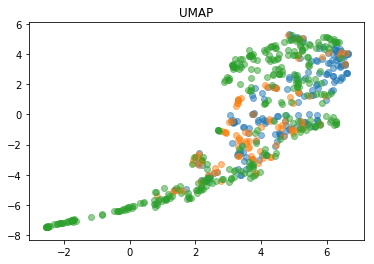

In [199]:
plt.title("UMAP")
plt.scatter(standard_embedding[np.array(y_test) == 0][:, 0], standard_embedding[np.array(y_test) == 0][:, 1], alpha=0.5)
plt.scatter(standard_embedding[np.array(y_test) == 1][:, 0], standard_embedding[np.array(y_test) == 1][:, 1], alpha=0.5)
plt.scatter(standard_embedding[np.array(y_test) == 2][:, 0], standard_embedding[np.array(y_test) == 2][:, 1], alpha=0.5);

In [200]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3,perplexity=40).fit_transform(encoded_imgs)

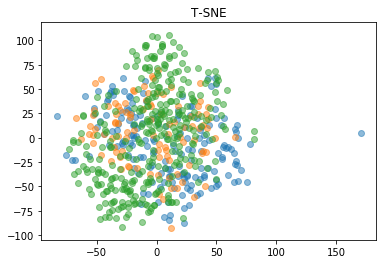

In [201]:
plt.title("T-SNE")
plt.scatter(tsne[np.array(y_test) == 0][:, 0], tsne[np.array(y_test) == 0][:, 1], alpha=0.5)
plt.scatter(tsne[np.array(y_test) == 1][:, 0], tsne[np.array(y_test) == 1][:, 1], alpha=0.5)
plt.scatter(tsne[np.array(y_test) == 2][:, 0], tsne[np.array(y_test) == 2][:, 1], alpha=0.5);